# Demo: Control of a wheel (stability)

Import modules and configure the notebook.

In [1]:
# These are standard modules
import time
import numpy as np
import sympy as sym
from scipy.signal import place_poles
from scipy import linalg
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# This is a custom interface to the pybullet simulator
import ae353_wheel

pybullet build time: Sep  3 2024 12:57:43


## Find state space model

The equation of motion is

$$c_1 \ddot{q} = \tau$$

where

* $q$ is the wheel angle
* $\tau$ is the wheel torque, i.e., the torque applied to the wheel by a motor on the ground

and where the value of $c_1$ is given as follows:

In [2]:
# Value of c1 for the example (do not change)
c1 = 1.0

# Values of other parameters that correspond to the coefficients c1 and c2 that we chose
m = 0.
J = c1

# Show c1
print(f'c1 = {c1}')

c1 = 1.0


Define symbolic variables:

In [3]:
q, v, tau = sym.symbols('q, v, tau')

Define ODEs:

In [4]:
f = sym.Matrix([
    v,
    tau / c1,
])

Convert floats to rationals:

In [5]:
f = sym.nsimplify(f, rational=True)

See the result:

In [6]:
f

Matrix([
[  v],
[tau]])

Choose equilibrium point:

In [7]:
q_e = 0.
v_e = 0.
tau_e = 0.

Linearize:

In [8]:
# Take derivatives
A_sym = f.jacobian([q, v])
B_sym = f.jacobian([tau])

# Create lambda functions so we can plug numbers into derivatives
A_num = sym.lambdify((q, v, tau), A_sym)
B_num = sym.lambdify((q, v, tau), B_sym)

# Evaluate lambda functions at equilibrium point
A = A_num(q_e, v_e, tau_e).astype(float)
B = B_num(q_e, v_e, tau_e).astype(float)

# Show result
A_num = sym.lambdify([q, v, tau], f.jacobian([q, v]))
A = A_num(q_e, v_e, tau_e).astype(float)
print(f'A =\n{A}')
print('')
B_num = sym.lambdify([q, v, tau], f.jacobian([tau]))
B = B_num(q_e, v_e, tau_e).astype(float)
print(f'B =\n{B}')

A =
[[0. 1.]
 [0. 0.]]

B =
[[0.]
 [1.]]


The state-space model is

$$\dot{x} = Ax+Bu$$

with $A$ and $B$ computed as above and with the state and input defined as

$$x = \begin{bmatrix} q - q_e \\ v - v_e \end{bmatrix} \qquad\qquad u = \begin{bmatrix} \tau - \tau_e \end{bmatrix}.$$

## Prepare to do simulations

Create an instance of the `Simulator` class with particular values of `roll` (angle of ground), `mass`, and `inertia`.

In [9]:
simulator = ae353_wheel.Simulator(
    display=True,
    roll = 0.,
    mass=m,
    inertia=J,
)

argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Define a function to plot results.

In [74]:
def show_results(
        data,
        qe, ve, taue,
        x1_num=None, x2_num=None, u1_num=None,
        q_num=None, v_num=None, tau_num=None,
    ):
    
    t = data['t']
    q = data['wheel_angle']
    v = data['wheel_velocity']
    tau = data['wheel_torque']
    tau_cmd = data['wheel_torque_command']
    x1 = q - qe
    x2 = v - ve
    u1 = tau - taue
    u1_cmd = tau_cmd - taue
    
    fig, ((ax_q, ax_x1), (ax_v, ax_x2), (ax_tau, ax_u1)) = plt.subplots(
        3, 2, figsize=(15, 10), sharex=True,
    )

    ax_q.plot(t, q, label='$q$', linewidth=4)
    ax_q.plot(t, np.ones_like(t) * qe, '--', label='$q_e$', linewidth=4)
    
    ax_v.plot(t, v, label='$v$', linewidth=4)
    ax_v.plot(t, np.ones_like(t) * ve, '--', label='$v_e$', linewidth=4)
    
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, np.ones_like(t) * taue, '--', label=r'$\tau_e$', linewidth=4)
    
    ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
    ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
    ax_u1.plot(t, u1, label='$u_1$', linewidth=4)
    
    ax_tau.plot(t, tau_cmd, '-.', label=r'$\tau$ (command)', linewidth=3, color='C6')
    ax_u1.plot(t, u1_cmd, '-.', label='$u_1$ (command)', linewidth=3, color='C6')
    
    if q_num is not None: # <-- should really check if all *_num are not None!
        ax_q.plot(t, q_num, ':', label='$q$ (linear)', linewidth=6, color='C3')
        ax_v.plot(t, v_num, ':', label='$v$ (linear)', linewidth=6, color='C3')
        ax_tau.plot(t, tau_num, ':', label=r'$\tau$ (linear)', linewidth=6, color='C3')
        ax_x1.plot(t, x1_num, ':', label='$x_1$ (linear)', linewidth=6, color='C3')
        ax_x2.plot(t, x2_num, ':', label='$x_2$ (linear)', linewidth=6, color='C3')
        ax_u1.plot(t, u1_num, ':', label='$u_1$ (linear)', linewidth=6, color='C3')
    
    tau_max = np.ones_like(t) * simulator.tau_max
    ax_tau.plot(t, tau_max, '--', label=r'$\tau$ (max)', linewidth=2, color='C2', zorder=0)
    ax_tau.plot(t, - tau_max, '--', linewidth=2, color='C2', zorder=0)
    ax_u1.plot(t, tau_max - tau_e, '--', label=r'$u_1$ (max)', linewidth=2, color='C2', zorder=0)
    ax_u1.plot(t, - tau_max - tau_e, '--', linewidth=2, color='C2', zorder=0)
            
    ax_q.grid()
    ax_q.legend(fontsize=16)
    ax_q.tick_params(labelsize=14)
    ax_q.set_ylim(qe - 2., qe + 2.)
    
    ax_v.grid()
    ax_v.legend(fontsize=16)
    ax_v.tick_params(labelsize=14)
    ax_v.set_ylim(-2, 2)
    
    ax_tau.grid()
    ax_tau.legend(fontsize=16, loc='upper right')
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

    ax_x1.grid()
    ax_x1.legend(fontsize=16)
    ax_x1.tick_params(labelsize=14)
    ax_x1.set_ylim(-2., 2.)
        
    ax_x2.grid()
    ax_x2.legend(fontsize=16)
    ax_x2.tick_params(labelsize=14)
    ax_x2.set_ylim(-2, 2)
    
    ax_u1.grid()
    ax_u1.legend(fontsize=16, loc='upper right')
    ax_u1.tick_params(labelsize=14)
    ax_u1.set_ylim(taue + -1.2 * simulator.tau_max, taue + 1.2 * simulator.tau_max)
    
    ax_tau.set_xlabel('time (s)', fontsize=20)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])
    ax_u1.set_xlabel('time (s)', fontsize=20)
    ax_u1.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Define a function to get the numerical solution $x(t)$ to the closed-loop system, using the matrix exponential.

In [61]:
def get_solution_numeric(A, B, K, q_e, v_e, tau_e, q_i, v_i, data):
    # Define initial conditions
    x0 = np.array([
        q_i - q_e,
        v_i - v_e,
    ])

    # Create empty arrays to hold state and input at each time
    x = []
    u = []

    # Compute (linear) state and input at each time
    for t in data['t']:
        xt = linalg.expm((A - B @ K) * t) @ x0
        ut = - K @ xt
        x.append(xt)
        u.append(ut)
    x = np.array(x)
    u = np.array(u)

    # Get components of x(t) and u(t)
    x1_num = x[:, 0]
    x2_num = x[:, 1]
    u1_num = u[:, 0]

    # Compute q(t), v(t), and tau(t) from x1(t), x2(t), and u1(t)
    q_num = x1_num + q_e
    v_num = x2_num + v_e
    tau_num = u1_num + tau_e

    return q_num, v_num, tau_num, x1_num, x2_num, u1_num

Define a function to get the symbolic solution $x(t)$ to the closed-loop system, using the matrix exponential.

In [62]:
def get_solution_symbolic(A, B, K, q_e, v_e, q_i, v_i):
    # Model
    A_sym = sym.nsimplify(sym.Matrix(A), rational=True)
    B_sym = sym.nsimplify(sym.Matrix(B), rational=True)
    K_sym = sym.nsimplify(sym.Matrix(K), rational=True)

    # Variables
    t = sym.symbols('t', real=True)

    # Initial condition
    x0 = sym.nsimplify(sym.Matrix([q_i - q_e, v_i - v_e]), rational=True)

    # Solution
    x_sym = sym.exp((A_sym - B_sym @ K_sym) * t) @ x0

    return x_sym

Define a controller that maps sensor measurements (`wheel_angle` and `wheel_velocity`) to actuator commands (`wheel_torque`). By default, it chooses to apply zero torque to the wheel. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [63]:
class Controller:
    def __init__(self, K, q_e, v_e, tau_e):
        self.K = K
        self.q_e = q_e
        self.v_e = v_e
        self.tau_e = tau_e
    
    def reset(self):
        pass
    
    def run(self, t, wheel_angle, wheel_velocity, target_angle):
        """
        INPUTS
         t = current time (s)
         wheel_angle = angle of wheel (rad)
         wheel_velocity = angular of wheel (rad / s)
        
        OUTPUTS
         wheel_torque = torque applied to wheel by motor on ground (N m)
        """
        
        x = np.array([
            wheel_angle - self.q_e,
            wheel_velocity - self.v_e,
        ])

        x_des = np.array([
            target_angle - self.q_e,
            0.,
        ])

        u = - self.K @ (x - x_des)
        wheel_torque = u[0] + self.tau_e
        
        return wheel_torque

Define a function to run a simulation and show all the results.

In [75]:
def run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: 0., pause=1., show_linear=True):
    # Create an instance of the controller
    controller = Controller(K, q_e, v_e, tau_e)

    # Reset the simulator
    simulator.reset(wheel_angle=q_i, wheel_velocity=v_i)

    # Reset the controller
    controller.reset()

    # Pause before running
    time.sleep(pause)

    # Run the simulator
    data = simulator.run(controller, target, max_time=max_time)

    # Get numeric solution
    q_num, v_num, tau_num, x1_num, x2_num, u1_num = get_solution_numeric(A, B, K, q_e, v_e, tau_e, q_i, v_i, data)
    
    # Get symbolic solution
    x_sym = get_solution_symbolic(A, B, K, q_e, v_e, q_i, v_i)

    # Show numeric solution
    if show_linear:
        show_results(
            data,                       # <-- data from simulation
            q_e, v_e, tau_e,            # <-- equilibrium point
            x1_num, x2_num, u1_num,     # <-- solution to (closed-loop) linear system
            q_num, v_num, tau_num,      # <-- equivalent, approximate solution to (closed-loop) nonlinear system
        )
    else:
        show_results(
            data,                       # <-- data from simulation
            q_e, v_e, tau_e,            # <-- equilibrium point
            None, None, None,           # <-- solution to (closed-loop) linear system
            None, None, None,           # <-- equivalent, approximate solution to (closed-loop) nonlinear system
        )

    # Show symbolic solution
    display(Markdown(fr'$$\Huge x(t) \; = \; e^{{(A - BK)t}} x(0) \; = \; \begin{{bmatrix}} {sym.latex(x_sym[0])} \\[1em] {sym.latex(x_sym[1])} \end{{bmatrix}}$$'))

## Actually do simulations

### Zero initial wheel angle, non-zero target angle

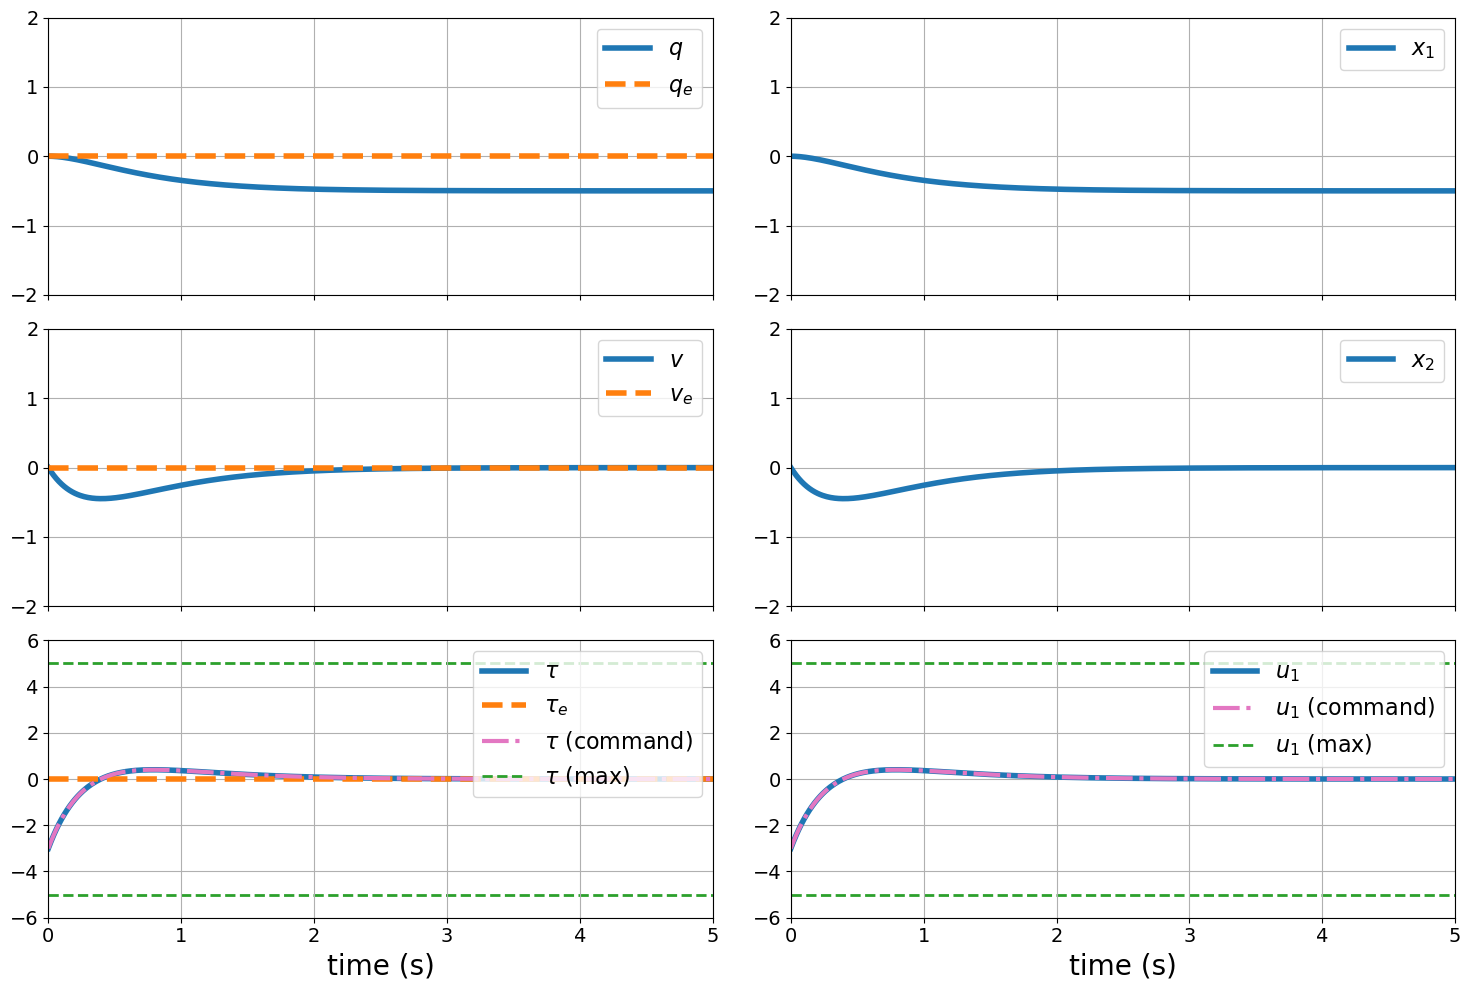

$$\Huge x(t) \; = \; e^{(A - BK)t} x(0) \; = \; \begin{bmatrix} 0 \\[1em] 0 \end{bmatrix}$$

$$\Huge s_1 = -2 \qquad s_2 = -3$$

In [82]:
# Choose K
K = np.array([[6., 5.]])

# Choose initial conditions
q_i =  0.
v_i = 0.

# Run simulation
run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: -0.5, show_linear=False)

# Find and show eigenvalues of $A - BK$
s = linalg.eigvals(A - B @ K)
s1_str = sym.latex(sym.nsimplify(s[0]), imaginary_unit='j')
s2_str = sym.latex(sym.nsimplify(s[1]), imaginary_unit='j')
display(Markdown(fr'$$\Huge s_1 = {s1_str} \qquad s_2 = {s2_str}$$'))

### Non-zero initial wheel angle, zero target angle

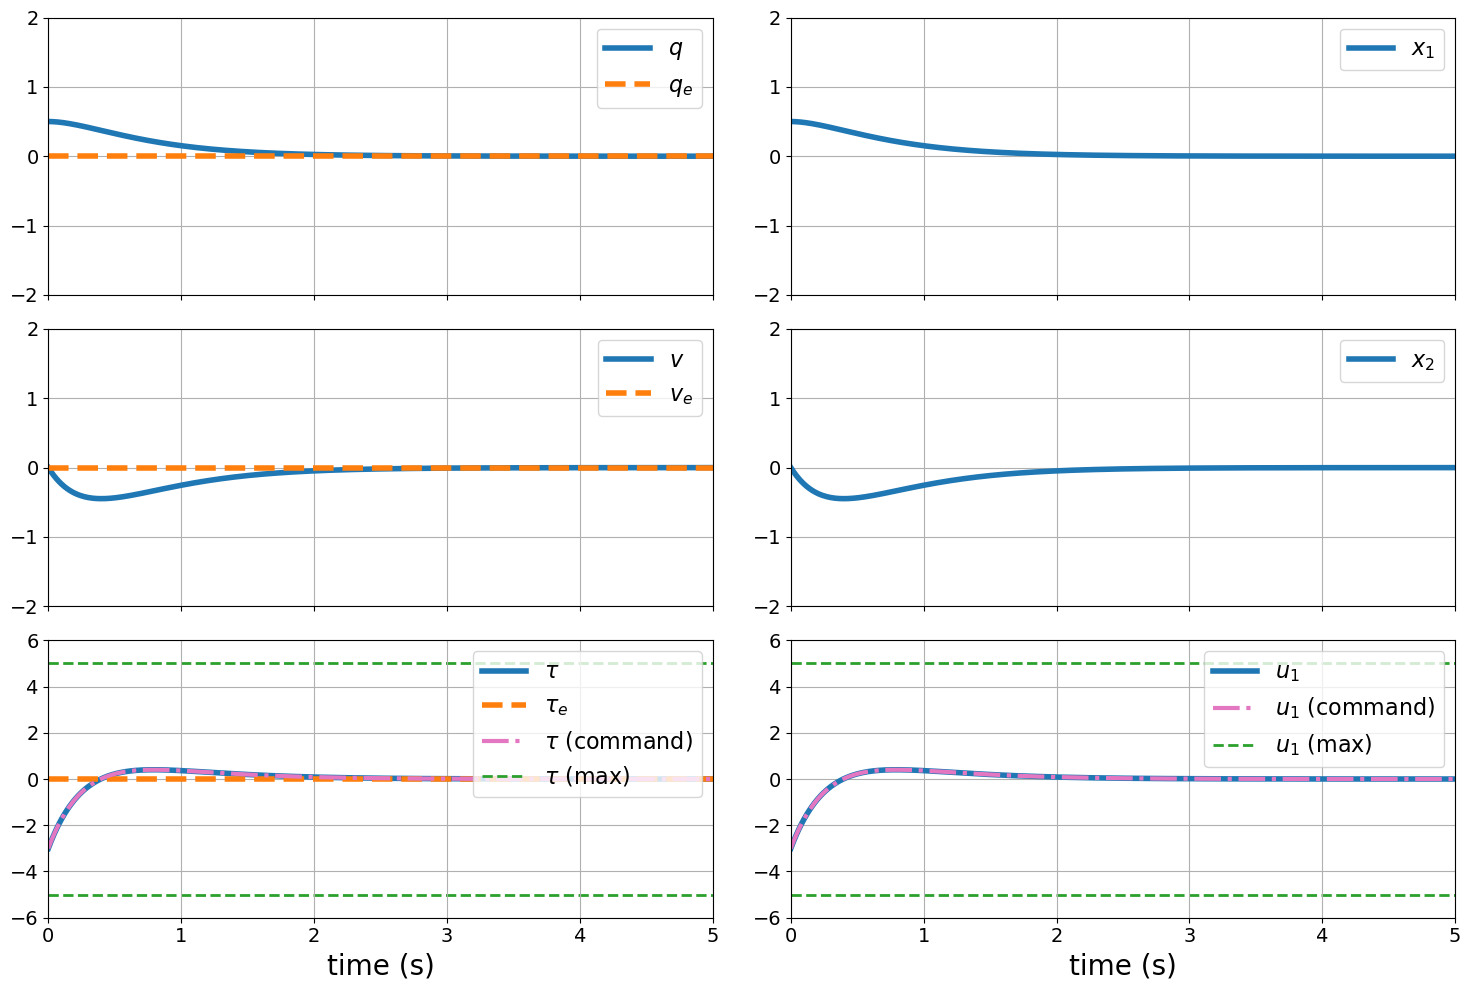

$$\Huge x(t) \; = \; e^{(A - BK)t} x(0) \; = \; \begin{bmatrix} \frac{3 e^{- 2 t}}{2} - e^{- 3 t} \\[1em] - 3 e^{- 2 t} + 3 e^{- 3 t} \end{bmatrix}$$

$$\Huge s_1 = -2 \qquad s_2 = -3$$

In [83]:
# Choose K
K = np.array([[6., 5.]])

# Choose initial conditions
q_i =  0.5
v_i = 0.

# Run simulation
run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: 0., show_linear=False)

# Find and show eigenvalues of $A - BK$
s = linalg.eigvals(A - B @ K)
s1_str = sym.latex(sym.nsimplify(s[0]), imaginary_unit='j')
s2_str = sym.latex(sym.nsimplify(s[1]), imaginary_unit='j')
display(Markdown(fr'$$\Huge s_1 = {s1_str} \qquad s_2 = {s2_str}$$'))

### Same thing with solution predicted by matrix exponential

Initial wheel angle is $q(0) = 0.5$.

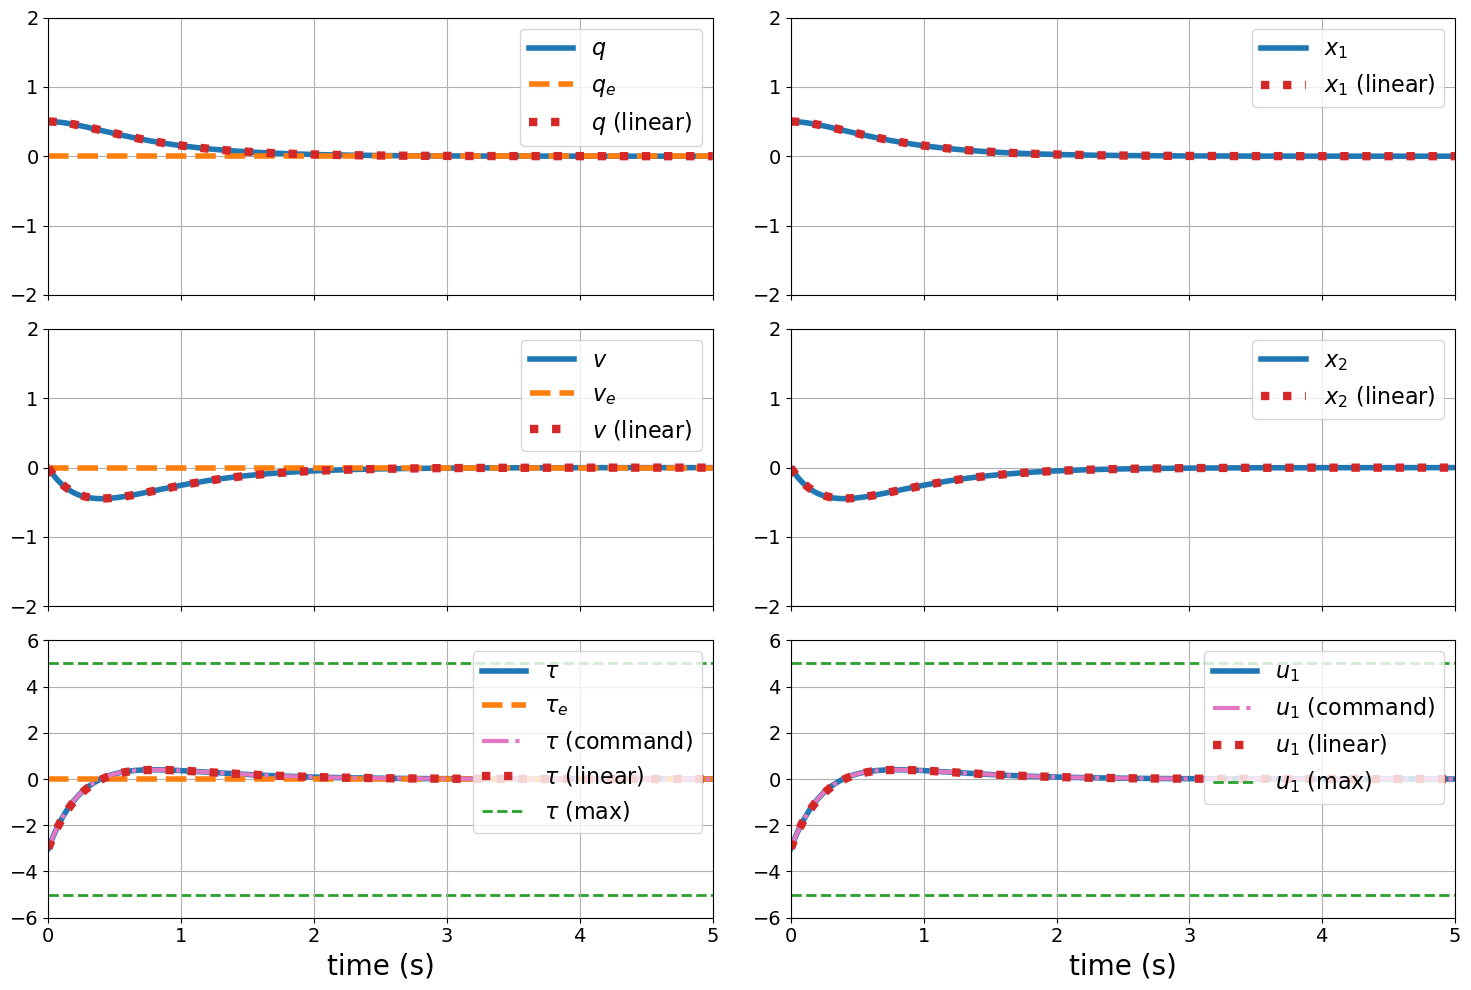

$$\Huge x(t) \; = \; e^{(A - BK)t} x(0) \; = \; \begin{bmatrix} \frac{3 e^{- 2 t}}{2} - e^{- 3 t} \\[1em] - 3 e^{- 2 t} + 3 e^{- 3 t} \end{bmatrix}$$

In [88]:
K = np.array([[6., 5.]])
q_i, v_i = 0.5, 0.
run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: 0.)

Initial wheel angle is $q(0) = 1.0$.

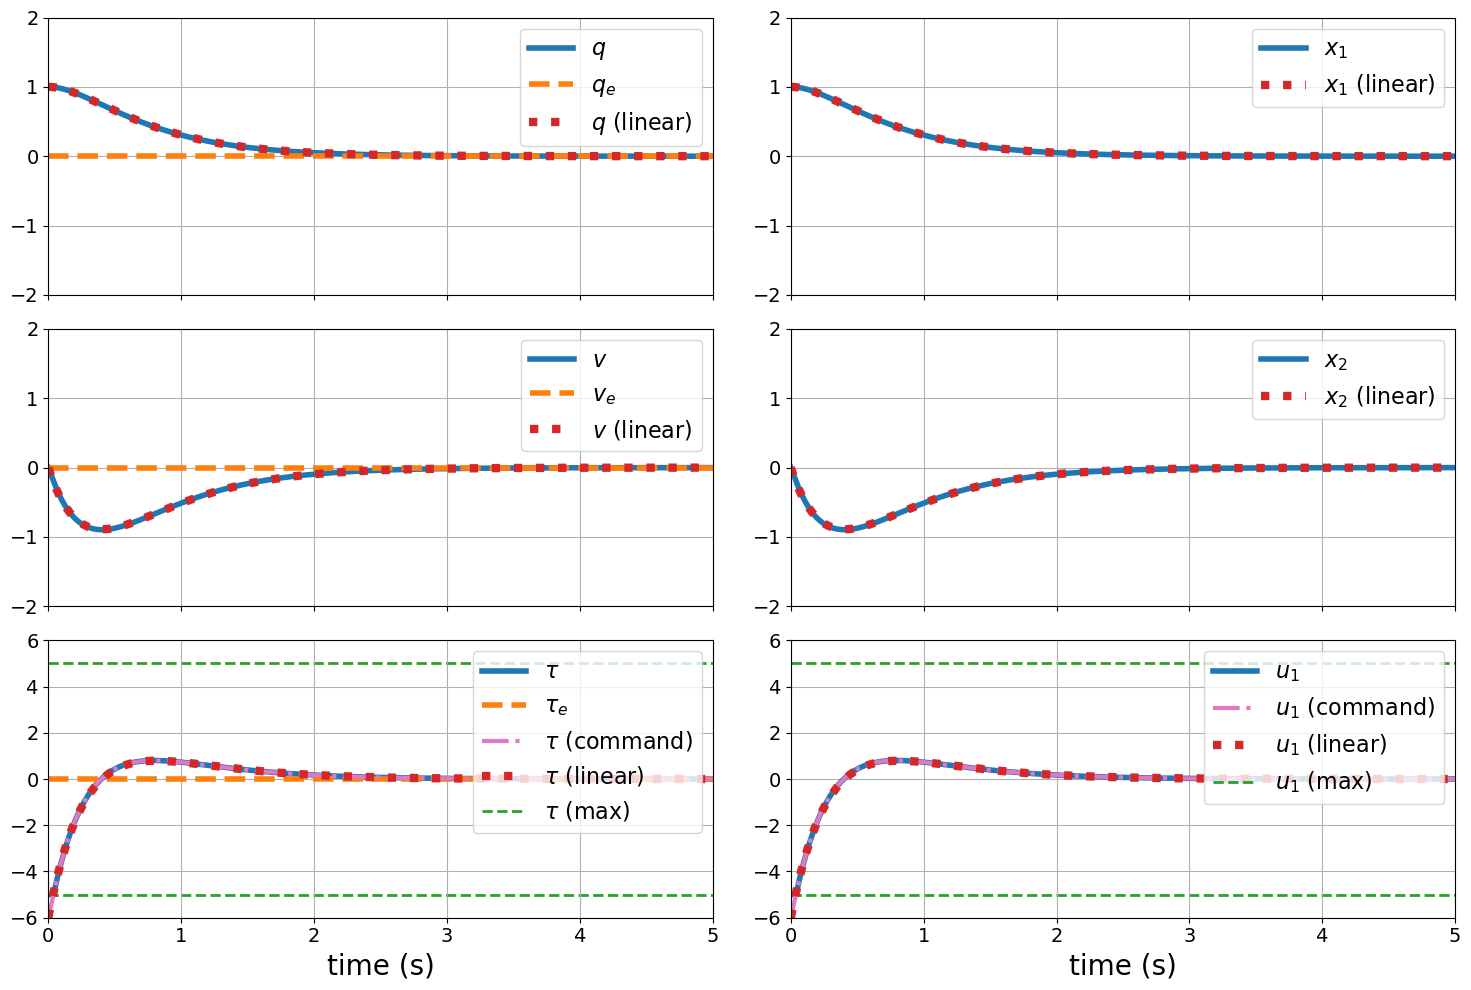

$$\Huge x(t) \; = \; e^{(A - BK)t} x(0) \; = \; \begin{bmatrix} 3 e^{- 2 t} - 2 e^{- 3 t} \\[1em] - 6 e^{- 2 t} + 6 e^{- 3 t} \end{bmatrix}$$

In [89]:
K = np.array([[6., 5.]])
q_i, v_i = 1., 0.
run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: 0.)

Initial wheel angle is $q(0) = 2.0$.

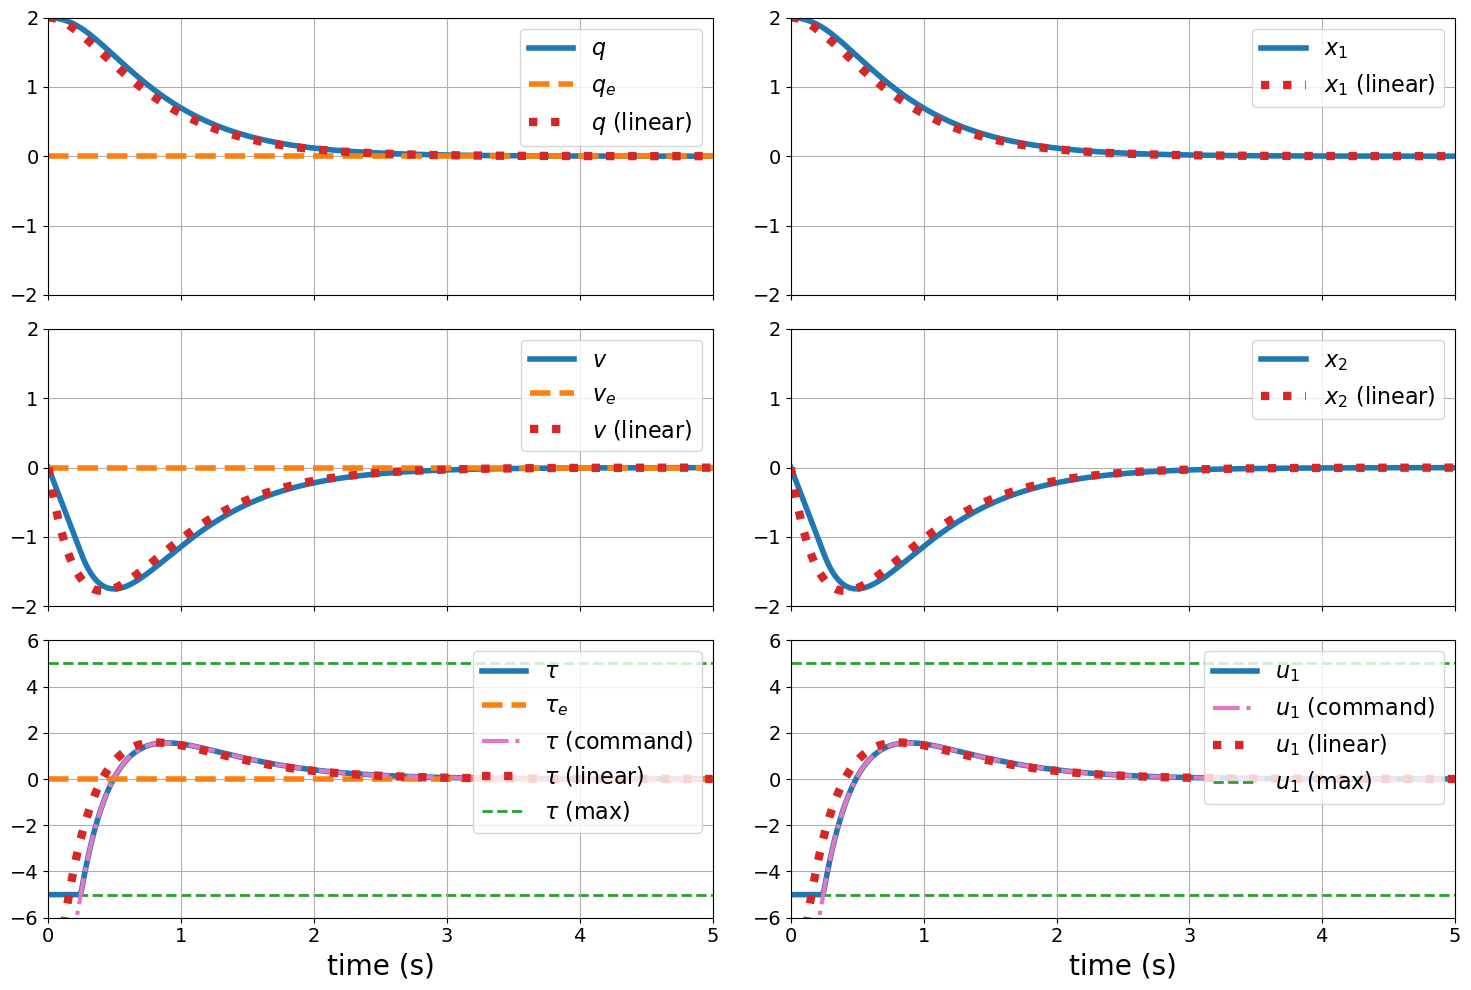

$$\Huge x(t) \; = \; e^{(A - BK)t} x(0) \; = \; \begin{bmatrix} 6 e^{- 2 t} - 4 e^{- 3 t} \\[1em] - 12 e^{- 2 t} + 12 e^{- 3 t} \end{bmatrix}$$

In [90]:
K = np.array([[6., 5.]])
q_i, v_i = 2., 0.
run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: 0.)

Initial wheel angle is $q(0) = 3.0$.

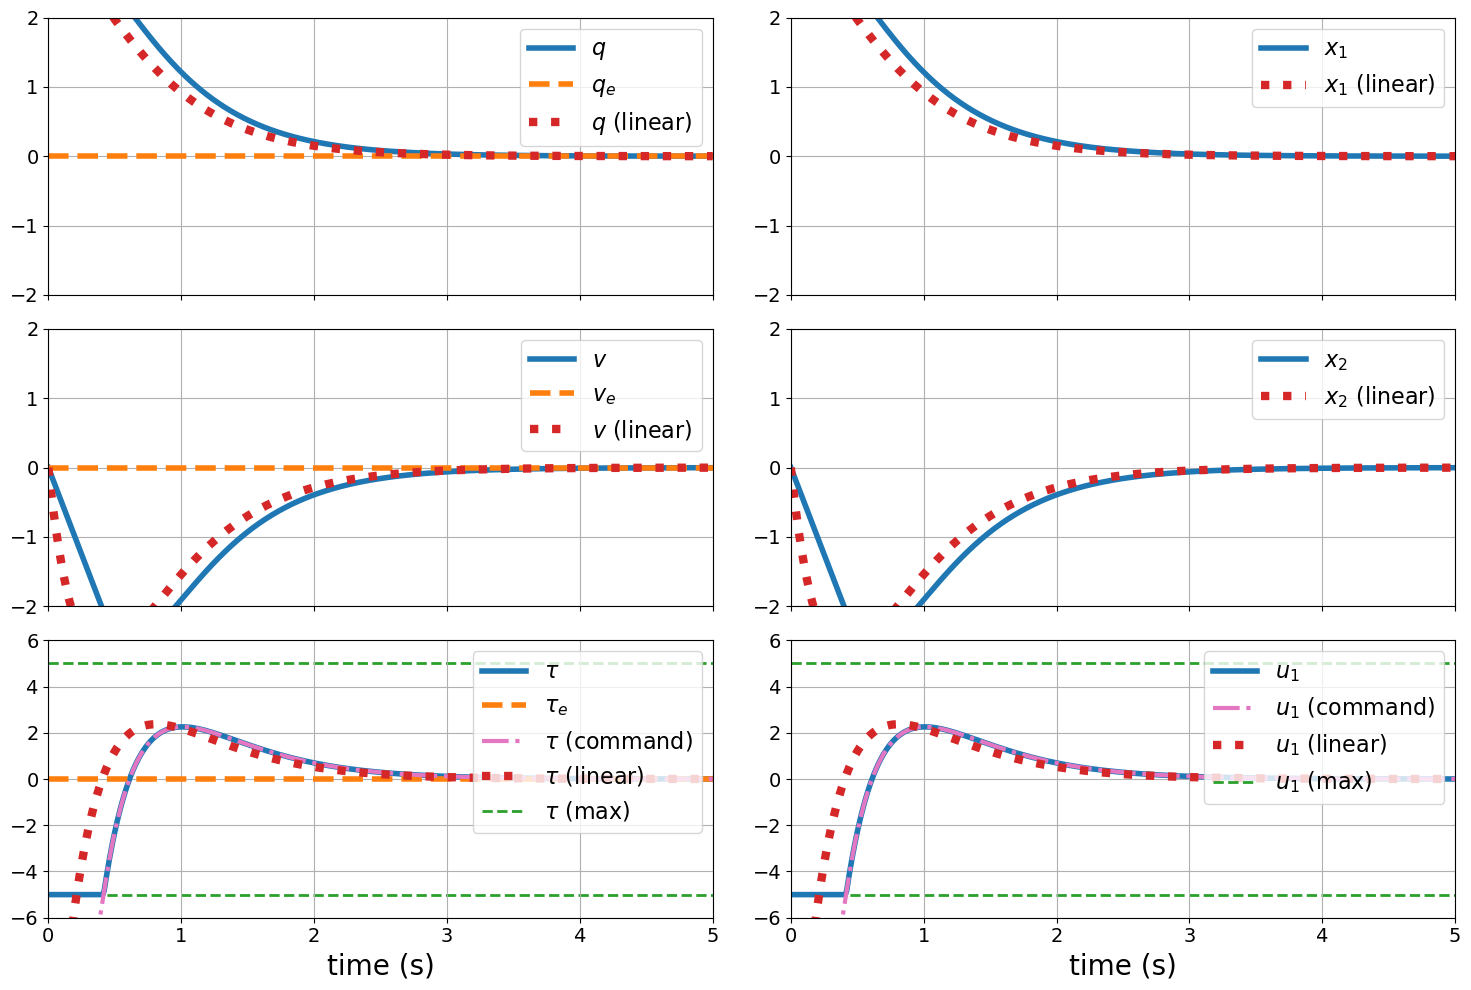

$$\Huge x(t) \; = \; e^{(A - BK)t} x(0) \; = \; \begin{bmatrix} 9 e^{- 2 t} - 6 e^{- 3 t} \\[1em] - 18 e^{- 2 t} + 18 e^{- 3 t} \end{bmatrix}$$

In [91]:
K = np.array([[6., 5.]])
q_i, v_i = 3., 0.
run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: 0.)

Redefine controller to limit difference between desired wheel angle and actual wheel angle.

In [95]:
class Controller:
    def __init__(self, K, q_e, v_e, tau_e):
        self.K = K
        self.q_e = q_e
        self.v_e = v_e
        self.tau_e = tau_e
    
    def reset(self):
        pass
    
    def run(self, t, wheel_angle, wheel_velocity, target_angle):
        """
        INPUTS
         t = current time (s)
         wheel_angle = angle of wheel (rad)
         wheel_velocity = angular of wheel (rad / s)
        
        OUTPUTS
         wheel_torque = torque applied to wheel by motor on ground (N m)
        """
        
        x = np.array([
            wheel_angle - self.q_e,
            wheel_velocity - self.v_e,
        ])

        if np.abs(target_angle - wheel_angle) > 1.:
            q_des = wheel_angle + 1. * (target_angle - wheel_angle) / np.abs(target_angle - wheel_angle)
        else:
            q_des = target_angle

        x_des = np.array([
            q_des - self.q_e,
            0.,
        ])

        u = - self.K @ (x - x_des)
        wheel_torque = u[0] + self.tau_e
        
        return wheel_torque

Initial wheel angle is $q(0) = 3.0$. Run simulation again with new controller.

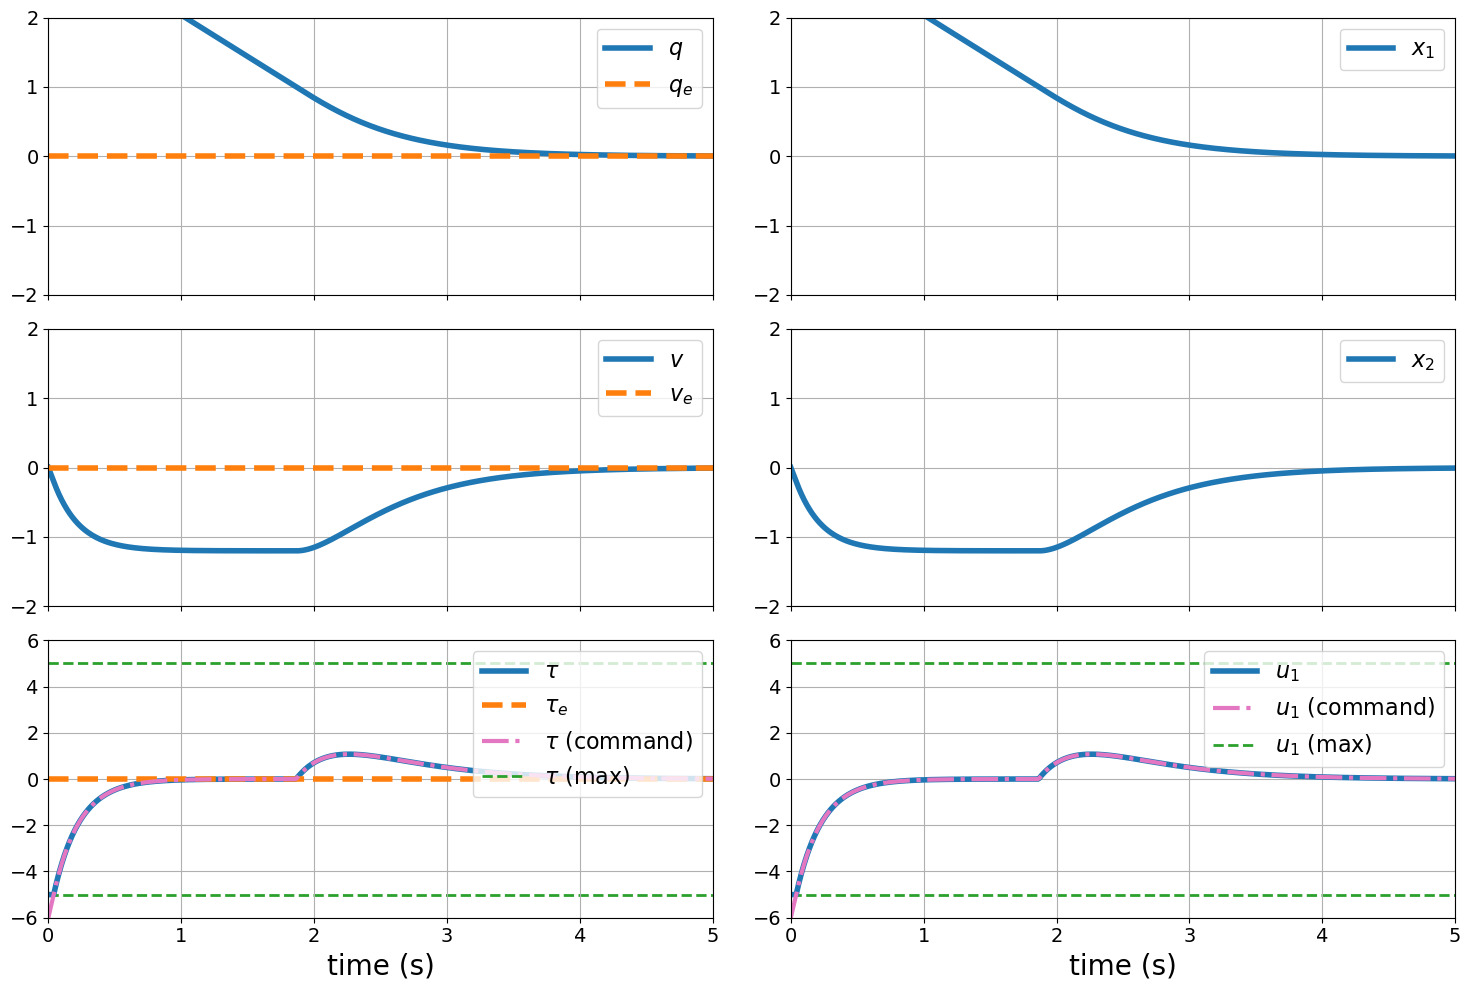

$$\Huge x(t) \; = \; e^{(A - BK)t} x(0) \; = \; \begin{bmatrix} 9 e^{- 2 t} - 6 e^{- 3 t} \\[1em] - 18 e^{- 2 t} + 18 e^{- 3 t} \end{bmatrix}$$

In [97]:
K = np.array([[6., 5.]])
q_i, v_i = 3., 0.
run_simulation(A, B, K, q_e, v_e, tau_e, q_i, v_i, max_time=5., target=lambda t: 0., show_linear=False)